# Prédire si un adhérent d'une médiathèque sera emprunteur ou non de document

Olivier Viollet, avril 2019, olivier.viollet[a]gmail.com

## Résumé

Cette étude crée des modèles afin de prédire si un adhérent d'une médiathèque publique empruntera, ou non, au moins un document durant l'année : les prédictions sont justes dans environ 70 % des cas. 

Plan :

1. Objectif et données
2. Exploration et transformation des données
3. Modéliser l'usage de la médiathèque
4. Evaluer les modèles

## 1. Objectif et données

L'objectif de cette étude est de concevoir des modèles d'apprentissage des données capables de prédire si un usager d'une médiathèque publique empruntera, ou non, au moins un document durant l'année à venir, à partir des caractéristiques de cet usager. Un tel modèle pourrait s'avérer utile à la médiathèque, en particulier pour cibler des actions d'encouragement en direction des publics qui n'empruntent pas de document.

Les données mobilisées ici proviennent de la Médiathèque La Grand Plage, à Roubaix, et concernent l'année **2017**, dans leur état au 15 avril 2019. Elles ont été mises à disposition par la mairie sur le site d'ouverture des données publiques françaises : https://www.data.gouv.fr/fr/datasets/caracteristiques-des-adherents-de-la-mediatheque-la-grand-plage-a-roubaix/

**15 112 adhérents** sont identifiés. En l'absence d'un dictionnaire des variables, certaines sont d'interprétation difficile. La variable cible est **"activite_emprunteur"**, qui distingue les adhérents de la médiathèque selon qu'ils ont emprunté ou non un document. Pour la prédire, seront utilisées les **variables explicatives** suivantes :

- la tranche d'âge de l'emprunteur ;
- son genre ;
- s'il est roubaisien ou non ;
- le nom de l'IRIS (localisation géographique) à Roubaix ; 
- sa commune de résidence ;
- des informations concernant le moment de son inscription et sa carte ;
- le nombre d'années d'adhésion ;
- le type d'inscription (gratuite ou payante).

Le jeu de données contient des **données manquantes** pour plusieurs variables explicatives.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils, to_categorical
from keras import regularizers
from keras import backend as K

from sklearn import metrics

# fonction de recodage
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [3]:
roubaix = pd.read_csv('caracteristiques-des-adherents-de-la-mediatheque-la-grand-plage-a-roubaix.csv',
                     encoding = 'utf-8', sep = ';', usecols = [2,9,10,12,13,14,15,16,17,18,26])
roubaix.info()
roubaix.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15112 entries, 0 to 15111
Data columns (total 11 columns):
activite_emprunteur            15112 non-null object
Tranches d'âge (2)             14848 non-null object
Roubaisien ou non              15112 non-null object
Nom de l'IRIS à Roubaix        10589 non-null object
Commune de résidence           15112 non-null object
inscription_attribut_action    1322 non-null object
inscription_attribut_zebre     784 non-null object
inscription_type_carte         15112 non-null object
nombre d'années d'adhésion     15111 non-null float64
type_inscription               15112 non-null object
sexe                           15112 non-null object
dtypes: float64(1), object(10)
memory usage: 1.3+ MB


,activite_emprunteur,Tranches d'âge (2),Roubaisien ou non,Nom de l'IRIS à Roubaix,Commune de résidence,inscription_attribut_action,inscription_attribut_zebre,inscription_type_carte,nombre d'années d'adhésion,type_inscription,sexe
0,Emprunteur,11 - 14 ans,Roubaisien,HOMMELET CENTRE,ROUBAIX,Action éducative,Arrêt Bus Place la de la Nation,Médiathèque,3.0,gratuite,Femme
1,Emprunteur,15 - 17 ans,Roubaisien,HOMMELET CENTRE,ROUBAIX,Action éducative,NaN,Médiathèque,3.0,gratuite,Femme
2,Emprunteur,15 - 17 ans,Roubaisien,NOUVEAU ROUBAIX,ROUBAIX,Action éducative,Arrêt Bus Boulevard de Fourmies,Médiathèque,1.0,gratuite,Femme
3,Emprunteur,25 - 29 ans,Non Roubaisien,NaN,CROIX,Action éducative,NaN,Médiathèque,12.0,gratuite,Femme
4,Emprunteur,11 - 14 ans,Roubaisien,PILE CENTRE,ROUBAIX,Action éducative,NaN,Médiathèque Plus,2.0,payante,Homme
5,Emprunteur,11 - 14 ans,Roubaisien,CUL DE FOUR,ROUBAIX,Action éducative,NaN,Médiathèque,0.0,gratuite,Femme
6,Emprunteur,11 - 14 ans,Roubaisien,ALMA SUD,ROUBAIX,Action éducative,NaN,Médiathèque,0.0,gratuite,Homme
7,Emprunteur,11 - 14 ans,Roubaisien,JUSTICE,ROUBAIX,Action éducative,NaN,Médiathèque,3.0,gratuite,Homme
8,Non emprunteur,15 - 17 ans,Non Roubaisien,NaN,CROIX,Action éducative,NaN,Médiathèque,0.0,gratuite,Homme
9,Non emprunteur,11 - 14 ans,Non Roubaisien,NaN,CROIX,Action éducative,NaN,Médiathèque,2.0,gratuite,Femme


## 2. Exploration et transformation des données

### Variable cible : emprunteurs et non-emprunteurs

Environ deux adhérents sur trois de la médiathèque ont emprunté en 2017. Ce déséquilibre nous conduira ultérieurement à transformer dans l'ensemble le jeu de données (cf. *partie 3. Modéliser l'usage de la médiathèque*).

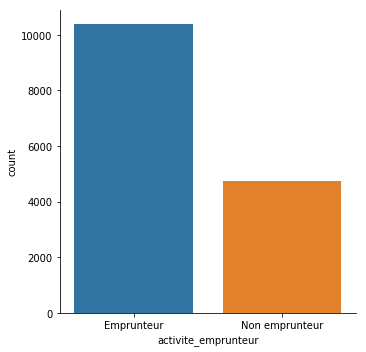

In [4]:
sns.catplot(x = 'activite_emprunteur', kind = 'count', data = roubaix)

### Variables explicatives :

### Tranche d'âge 

Pour les quelques valeurs manquantes est imputée la valeur "non disponible". Dans la plupart des tranches d'âge se retrouve la proportion entre deux tiers d'emprunteurs et un tiers de non emprunteurs, à quelques exceptions près, en particulier chez les 18-24 ans qui sont presqu'autant à emprunter qu'à ne pas emprunter, tandis que la grande majorité des 6-10 ans ou des 65 ans et plus n'emprunte pas de document. 

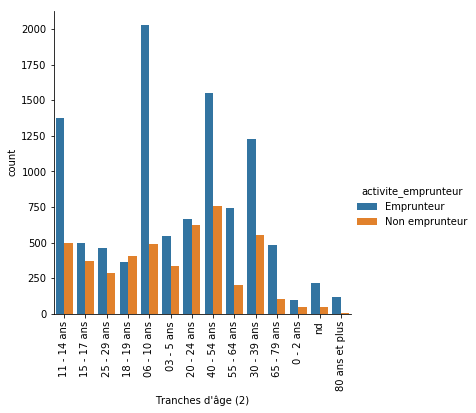

In [5]:
roubaix['Tranches d\'âge (2)'].fillna('nd', inplace = True)
sns.catplot(x = 'Tranches d\'âge (2)', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix).set_xticklabels(rotation=90)

### Roubaisiens et non-roubaisiens

On retrouve tant chez les roubaisiens que chez les non-roubaisiens la proportion entre deux tiers d'emprunteurs et un tiers de non-emprunteurs.

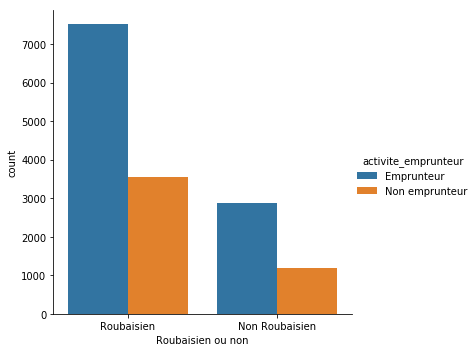

In [6]:
sns.catplot(x = 'Roubaisien ou non', hue = 'activite_emprunteur', kind = 'count', data = roubaix)

### Nom de l'IRIS à Roubaix

L'IRIS désigne portion géographique du territoire national découpée par l'INSEE à des fins démographiques. Hormis quelques exceptions, on retrouve la proportion entre deux tiers d'emprunteurs et un tiers de non-emprunteurs dans la plupart des IRIS.

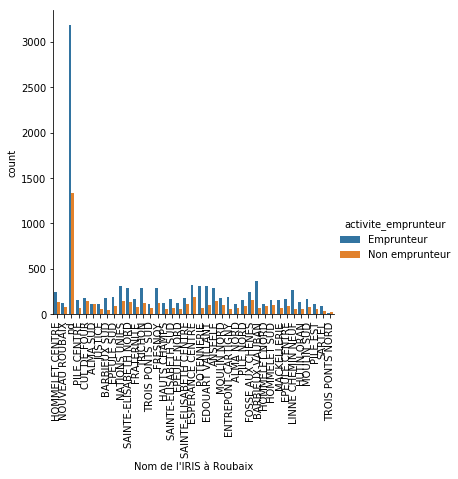

In [7]:
roubaix['Nom de l\'IRIS à Roubaix'].fillna('nd', inplace = True)
sns.catplot(x = 'Nom de l\'IRIS à Roubaix', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix).set_xticklabels(rotation=90)

### Commune de résidence

Les adhérents de la médiathèque proviennent pour une large majorité de Roubaix, commune dans laquelle apparait la proportion entre deux tiers d'emprunteurs et un tiers de non-emprunteurs. En revanche, la plupart des autres communes présentent des proportions légèrement différentes.

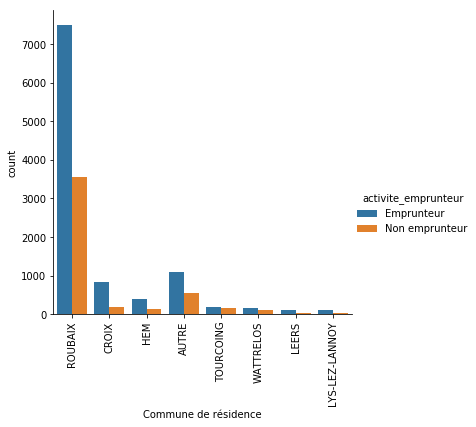

In [8]:
sns.catplot(x = 'Commune de résidence', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix).set_xticklabels(rotation=90)

### Insription_attribut_action

La signification de la variable est peu explicite. Il semblerait qu'elle indique si une occasion particulière - action éducative ou visite de classe - a entrainé l'adhésion à la médiathèque. La valeur est manquante pour la majorité des observations, nous conduisant à leur imputer la valeur "non disponible". La proportion de non emprunteurs est proche voire identique à celle des emprunteurs pour les adhérents inscrits lors d'une occasion particulière.

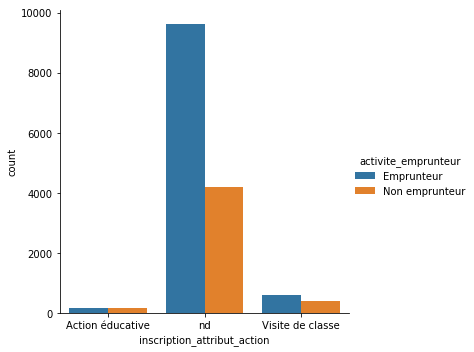

In [9]:
roubaix.inscription_attribut_action.fillna('nd', inplace = True)
sns.catplot(x = 'inscription_attribut_action', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix)

### Inscription_attribut_zebre

La signification de cette variable est également peu explicite. "Zèbre" désigne le nom donné au bibliobus de la médiathèque, en raison de son apparence physique. Les valeurs possibles sont les noms des arrêts du bibliobus. La valeur est manquante pour une grande majorité d'observations, pour laquelle on impute la valeur "non disponible". Le grand nombre d'arrêts nous conduit à les fusionner dans une même modalité "Arrêt". Il apparait dès lors que la quasi totalité des adhérents associés à un arrêt sont des emprunteurs.

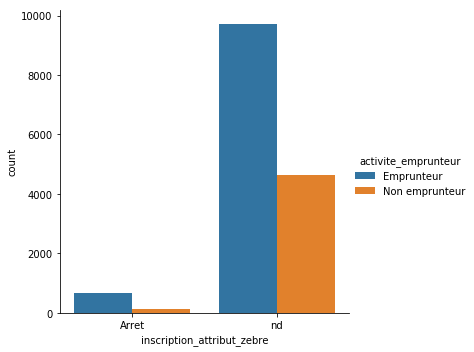

In [10]:
roubaix.inscription_attribut_zebre.fillna('nd', inplace = True)
series = pd.value_counts(roubaix.inscription_attribut_zebre)
mask = (series/series.sum() * 100).lt(1)  
roubaix['inscription_attribut_zebre'] = np.where(roubaix['inscription_attribut_zebre'].isin(series[mask].index),'Arret',
                                                 roubaix['inscription_attribut_zebre'])
sns.catplot(x = 'inscription_attribut_zebre', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix)

### Inscription_type_carte

La variable nous renseigne sur le type de carte de l'adhérent. Pour toutes les cartes autres que la carte "Médiathèque" seule, les proportions d'emprunteurs et de non emprunteurs sont très différentes de la proportion entre deux tiers d'emprunteurs et un tiers de non-emprunteurs observée sur l'ensemble des adhérents.

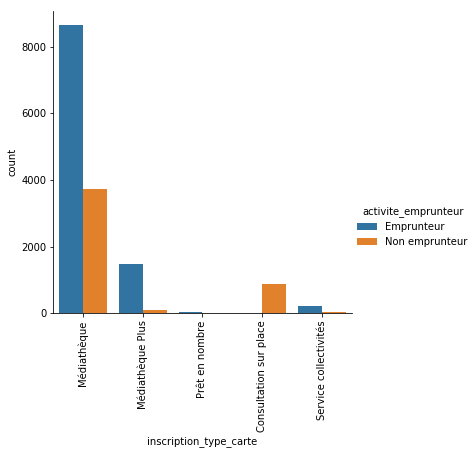

In [11]:
sns.catplot(x = 'inscription_type_carte', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix).set_xticklabels(rotation=90)

### Nombre d'années d'adhésion

La variable indique depuis combien d'années l'usager est adhérent de la médiathèque. La médiane (1 an) est imputée pour l'unique valeur manquante. Les adhérents plus anciens ont davantage tendance à emprunter des documents que les adhérents plus récents, sauf exceptions. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


count    15111.000000
mean         2.824168
std          3.822361
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         12.000000
Name: nombre d'années d'adhésion, dtype: float64


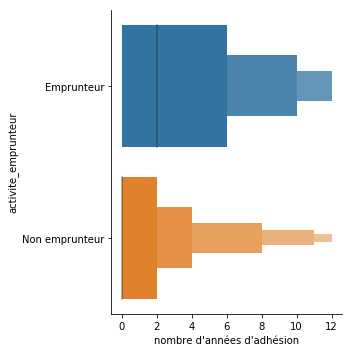

In [12]:
print(roubaix['nombre d\'années d\'adhésion'].describe())
roubaix['nombre d\'années d\'adhésion'].fillna(1.0, inplace = True) # imputer la médiane
sns.catplot(x = 'nombre d\'années d\'adhésion', y ='activite_emprunteur', kind = 'boxen', data = roubaix)

### Type d'inscription

Cette variable renseigne le type, gratuit ou payante, de l'inscription. Les inscrits payants, très minoritaires, ont presque tous emprunté en 2017. 

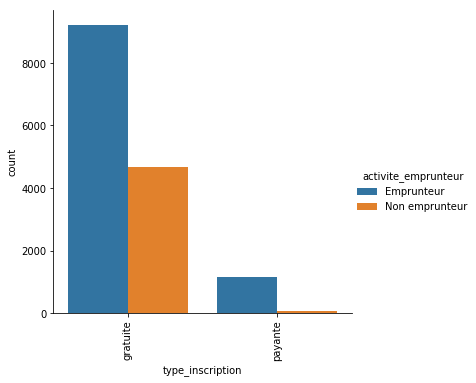

In [13]:
sns.catplot(x = 'type_inscription', hue = 'activite_emprunteur', 
            kind = 'count', data = roubaix).set_xticklabels(rotation=90)

### Genre

La valeur "autre" est imputée à la place de valeurs non explicites du jeu de données : "NP" et "NC". Les femmes adhérentes de la médiathèque apparaissent davantage que les hommes dans la catégorie des emprunteurs de document. 

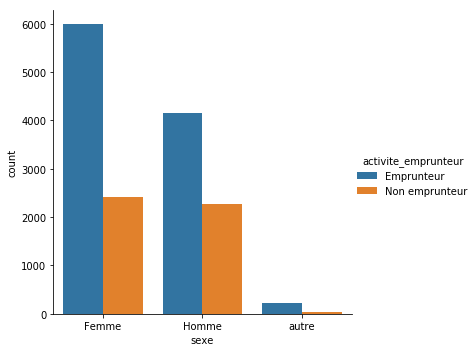

In [14]:
roubaix['sexe'] = coding(roubaix['sexe'], {'NP':'autre','NC':'autre'})
sns.catplot(x = 'sexe', hue = 'activite_emprunteur', kind = 'count', data = roubaix)

## 3. Modéliser l'usage de la médiathèque

### Mesure de performance

Le problème posé ici relève de la **classification**, binaire en l'occurrence, puisque les modèles devront prédire si un usager, à partir de ses caractéristiques, empruntera au moins un document ou non. Compte tenu de l'objectif fixé, il semble adéquat de recourir à deux mesures de performance : d'une part, le **taux de bonnes classifications** ; d'autre part, le **taux de non-emprunteurs correctement identifiés** (*recall* sur cette classe). En effet, l'objectif pratique du modèle serait d'identifier le plus d'adhérents qui auront tendance à ne pas emprunter de document, afin de les encourager à inverser leur usage de la médiathèque.

### Jeux de données

Des **variables binaires** sont obtenues à partir des variables catégoriques. Puis, **trois jeux de données** sont créés à partir du jeu de données initial : d'abord un jeu d'entrainement et un jeu de test, puis un jeu de validation est extrait du premier. Les modèles sont construits sur le jeu d'entrainement et leurs hyperparamètres ajustés sur le jeu de validation - sauf exception. Ce n'est que dans la partie 4. que nous pourrons jauger, grâce au jeu de test, de leur faculté à se généraliser.

A noter que les valeurs sont **centrées et réduites** dans un intervalle compris entre 0 et 1 car le jeu de données comprend une variable continue (nombre d'années d'adhésion). Elles sont ensuite transformées à l'aide de la technique **SMOTE** (*Synthetic Minority Over-sampling Technique*) afin d'équilibrer les deux catégories, emprunteurs et non-emprunteurs, dans le jeu d'entrainement. D'autres techniques auraient été possibles. 

In [15]:
# jeux de données

    # variable cible
Target = roubaix['activite_emprunteur']
roubaix.drop(columns = ['activite_emprunteur'], inplace=True)

    # variables binaires
predictors = pd.get_dummies(roubaix)

# jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

# jeux d'entrainement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
# centrer et réduire
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_preprocess = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_preprocess, columns = X_train.columns)
del X_train_preprocess
X_val_preprocess = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_preprocess, columns = X_val.columns)
del X_val_preprocess

In [17]:
# SMOTE
smote = SMOTE('all', random_state = 2, k_neighbors = 5) 
X_train_res, y_train = smote.fit_resample(X_train, pd.DataFrame(y_train))
X_train = pd.DataFrame(X_train_res, columns = X_train.columns)
del X_train_res
print(pd.value_counts(y_train))

Emprunteur        6652
Non emprunteur    6652
dtype: int64


### Régression logistique

A l'aide de la régression logistique, 69 % des prédictions du jeu de validation sont correctes et 71 % des non emprunteurs ont été correctement identifiés comme tels. 

In [18]:
# régression logistique
lr = LogisticRegression()
parameters = {'C': np.linspace(1, 20, 10)}
clf = GridSearchCV(lr, parameters, cv=10, verbose=5, n_jobs=-1)
clf.fit(X_train, y_train.ravel())
clf.best_params_ # 12

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


{'C': 11.555555555555555}

In [19]:
lr_def = LogisticRegression(C = 12, penalty = 'l1', verbose=5)
lr_def.fit(X_train, y_train)
y_pred_train = lr_def.predict(X_train)
y_pred_val = lr_def.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 70.9
print("Taux de classifications exactes sur le jeu de validation:", metrics.accuracy_score(y_val, y_pred_val)) # 69.2
print(metrics.classification_report(y_val, y_pred_val))
print(metrics.confusion_matrix(y_val, y_pred_val))

[LibLinear]Taux de classifications exactes sur le jeu d'entrainement : 0.708959711365003
Taux de classifications exactes sur le jeu de validation: 0.6923076923076923
                precision    recall  f1-score   support

    Emprunteur       0.84      0.68      0.75      1671
Non emprunteur       0.50      0.71      0.59       747

     micro avg       0.69      0.69      0.69      2418
     macro avg       0.67      0.70      0.67      2418
  weighted avg       0.74      0.69      0.70      2418

[[1143  528]
 [ 216  531]]


### Forêt aléatoire

Régularisée en vue de réduire le sur-apprentissage (*overfitting*), la forêt aléatoire réalise globalement 70 % de bonnes classifications et identifie correctement 69 % des non-emprunteurs. 

In [20]:
# forêt aléatoire
forest = RandomForestClassifier(criterion='entropy', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_val = forest.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 90.3
print("Taux de classifications exactes sur le jeu de validation:", metrics.accuracy_score(y_val, y_pred_val)) # 71.8
print(metrics.classification_report(y_val, y_pred_val))
print(metrics.confusion_matrix(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.9030366806975346
Taux de classifications exactes sur le jeu de validation: 0.717948717948718
                precision    recall  f1-score   support

    Emprunteur       0.79      0.80      0.80      1671
Non emprunteur       0.54      0.53      0.54       747

     micro avg       0.72      0.72      0.72      2418
     macro avg       0.67      0.67      0.67      2418
  weighted avg       0.72      0.72      0.72      2418

[[1337  334]
 [ 348  399]]


In [21]:
forest = RandomForestClassifier(criterion='entropy', random_state=1, n_jobs=-1,
                               max_depth = 3)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_val = forest.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 70.1
print("Taux de classifications exactes sur le jeu de validation:", metrics.accuracy_score(y_val, y_pred_val)) # 70.2
print(metrics.classification_report(y_val, y_pred_val))
print(metrics.confusion_matrix(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.7005411906193626
Taux de classifications exactes sur le jeu de validation: 0.7022332506203474
                precision    recall  f1-score   support

    Emprunteur       0.84      0.71      0.77      1671
Non emprunteur       0.51      0.69      0.59       747

     micro avg       0.70      0.70      0.70      2418
     macro avg       0.67      0.70      0.68      2418
  weighted avg       0.74      0.70      0.71      2418

[[1184  487]
 [ 233  514]]


### Support vector machine

Si le SVM réalise globalement moins de prédictions justes (68 %), il s'avère en revanche plus efficace pour identifier les non-emprunteurs puisque trois non-emprunteurs sur quatre l'ont été.

In [22]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 72.1
print("Taux de classifications exactes sur le jeu de validation:", metrics.accuracy_score(y_val, y_pred_val)) # 67.7
print(metrics.classification_report(y_val, y_pred_val))
print(metrics.confusion_matrix(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.7207606734816596
Taux de classifications exactes sur le jeu de validation: 0.6774193548387096
                precision    recall  f1-score   support

    Emprunteur       0.85      0.65      0.74      1671
Non emprunteur       0.49      0.74      0.59       747

     micro avg       0.68      0.68      0.68      2418
     macro avg       0.67      0.69      0.66      2418
  weighted avg       0.74      0.68      0.69      2418

[[1087  584]
 [ 196  551]]


### XGboost

Le *gradient boosting machine*, dans sa version XGboost, et régularisé, apporte 71 % de bonnes classifications et repère correctement plus de deux non-emprunteurs sur trois. 

In [23]:
y_train = pd.DataFrame(y_train)
y_train[0] = coding(y_train[0], {'Emprunteur': 0, 
       'Non emprunteur':1}) 
xg_train = xgb.DMatrix(X_train, label= y_train.values)

In [24]:
y_val = pd.DataFrame(y_val)
y_val["activite_emprunteur"] = coding(y_val["activite_emprunteur"], {'Emprunteur': 0, 
       'Non emprunteur':1}) 
xg_validation = xgb.DMatrix(X_val)

In [25]:
params = {
    "eta": 0.3,
    "objective": "multi:softmax",
    "silent": 1,
    'n_estimators': 40,
    "eval_metric": "merror",
    'num_class' : 2}

model = xgb.train(params, xg_train, 15)

    # prédictions
y_pred_train = model.predict(xg_train)
y_pred_val = model.predict(xg_validation)

print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 77.1
print("Taux de classifications exactes sur le jeu de validation:", metrics.accuracy_score(y_val, y_pred_val)) # 71.1
print(metrics.classification_report(y_val, y_pred_val))
print(metrics.confusion_matrix(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.7707456404088996
Taux de classifications exactes sur le jeu de validation: 0.7105045492142267
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1671
           1       0.52      0.67      0.59       747

   micro avg       0.71      0.71      0.71      2418
   macro avg       0.68      0.70      0.68      2418
weighted avg       0.74      0.71      0.72      2418

[[1219  452]
 [ 248  499]]


In [26]:
params = {
    "eta": 0.3,
    "max_depth":5,
    "objective": "multi:softmax",
    "silent": 1,
    'n_estimators': 40,
    "eval_metric": "merror",
    'num_class' : 2}

model = xgb.train(params, xg_train, 15)

    # prédictions
y_pred_train = model.predict(xg_train)
y_pred_val = model.predict(xg_validation)

print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 75.8
print("Taux de classifications exactes sur le jeu de validation:", metrics.accuracy_score(y_val, y_pred_val)) # 70.8
print(metrics.classification_report(y_val, y_pred_val))
print(metrics.confusion_matrix(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.7582681900180397
Taux de classifications exactes sur le jeu de validation: 0.7080231596360629
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1671
           1       0.52      0.68      0.59       747

   micro avg       0.71      0.71      0.71      2418
   macro avg       0.68      0.70      0.68      2418
weighted avg       0.74      0.71      0.72      2418

[[1207  464]
 [ 242  505]]


### Réseau de neurones

Les meilleurs hyperparamètres que nous avons recherchés sur le réseau profond de neurones ont permis de correctement classer 71 % des adhérents mais seuls 62 % des non-emprunteurs ont bien été identifiés. 

In [28]:
dummy_y_train = to_categorical(y_train)
dummy_y_val = to_categorical(y_val)

In [29]:
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, dummy_y_train, epochs=20, validation_data = (X_val, dummy_y_val), verbose=1) # 70.9

Train on 13304 samples, validate on 2418 samples
Epoch 1/20
13304/13304 [==============================] - 1s 42us/step - loss: 0.5784 - acc: 0.6769 - val_loss: 0.5584 - val_acc: 0.6745
Epoch 2/20
13304/13304 [==============================] - 0s 21us/step - loss: 0.5344 - acc: 0.7105 - val_loss: 0.5422 - val_acc: 0.6911
Epoch 3/20
13304/13304 [==============================] - 0s 20us/step - loss: 0.5254 - acc: 0.7195 - val_loss: 0.5505 - val_acc: 0.6774
Epoch 4/20
13304/13304 [==============================] - 0s 21us/step - loss: 0.5148 - acc: 0.7252 - val_loss: 0.5237 - val_acc: 0.7035
Epoch 5/20
13304/13304 [==============================] - 0s 19us/step - loss: 0.5032 - acc: 0.7383 - val_loss: 0.5718 - val_acc: 0.6625
Epoch 6/20
13304/13304 [==============================] - 0s 19us/step - loss: 0.4937 - acc: 0.7407 - val_loss: 0.5374 - val_acc: 0.7072
Epoch 7/20
13304/13304 [==============================] - 0s 20us/step - loss: 0.4836 - acc: 0.7520 - val_loss: 0.5324 - val_acc:

In [30]:
K.clear_session()

model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, dummy_y_train, epochs=20, validation_data = (X_val, dummy_y_val), verbose=1)
y_pred_val = model.predict_classes(X_val) # 71.5
print(metrics.classification_report(y_val, y_pred_val))

K.clear_session()

Train on 13304 samples, validate on 2418 samples
Epoch 1/20
13304/13304 [==============================] - 1s 41us/step - loss: 0.6418 - acc: 0.6029 - val_loss: 0.5504 - val_acc: 0.6828
Epoch 2/20
13304/13304 [==============================] - 0s 22us/step - loss: 0.5729 - acc: 0.6827 - val_loss: 0.5395 - val_acc: 0.6853
Epoch 3/20
13304/13304 [==============================] - 0s 22us/step - loss: 0.5521 - acc: 0.6994 - val_loss: 0.5220 - val_acc: 0.7089
Epoch 4/20
13304/13304 [==============================] - 0s 21us/step - loss: 0.5471 - acc: 0.7052 - val_loss: 0.5347 - val_acc: 0.6973
Epoch 5/20
13304/13304 [==============================] - 0s 22us/step - loss: 0.5381 - acc: 0.7134 - val_loss: 0.5314 - val_acc: 0.7055
Epoch 6/20
13304/13304 [==============================] - 0s 21us/step - loss: 0.5336 - acc: 0.7190 - val_loss: 0.5441 - val_acc: 0.6919
Epoch 7/20
13304/13304 [==============================] - 0s 22us/step - loss: 0.5314 - acc: 0.7221 - val_loss: 0.5406 - val_acc:

## 4. Evaluer la modélisation

Les jeux d'entrainement et de test sont recréés. Ils sont **centrés et réduits**, puis le jeu d'entrainement seul est transformé à l'aide du **SMOTE** afin d'équilibrer le nombre d'emprunteurs et de non emprunteurs en son sein. Les modèles sont entrainés une ultime fois sur les jeux d'entrainement à l'aide des hyperparamètres trouvés sur le jeu de validation dans la partie précédente, puis évalués sur le jeu de test.

C'est le modèle **XGboost** qui obtient le **meilleur taux de bonnes classifications**, avec 70 % des adhérents qui ont bien été classés en emprunteurs ou non emprunteurs. Toutefois, si l'objectif prioritaire est d'**identifier les non emprunteurs**, le **SVM** est davantage recommandé puisqu'il parvient à repérer comme tels 72 % des non emprunteurs. 

A noter par ailleurs que les algorithmes divergent dans l'importance qu'ils confèrent aux variables explicatives pour dégager leurs prédictions : par exemple, si le nombre d'années d'adhésion s'avère très utile au XGboost, il l'est beaucoup moins pour la forêt aléatoire, laquelle recourt en priorité au type de carte de l'adhérent. 

In [31]:
# jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

In [32]:
# centrer et réduire
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_preprocess = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_preprocess, columns = X_train.columns)
del X_train_preprocess
X_test_preprocess = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_preprocess, columns = X_test.columns)
del X_test_preprocess

In [33]:
# SMOTE
smote = SMOTE('all', random_state = 2, k_neighbors = 5) 
X_train_res, y_train = smote.fit_resample(X_train, pd.DataFrame(y_train))
X_train = pd.DataFrame(X_train_res, columns = X_train.columns)
del X_train_res
print(pd.value_counts(y_train))

Emprunteur        8323
Non emprunteur    8323
dtype: int64


### Régression logistique

In [34]:
lr_def = LogisticRegression(C = 12, penalty = 'l1', verbose=5)
lr_def.fit(X_train, y_train)
y_pred_train = lr_def.predict(X_train)
y_pred_test = lr_def.predict(X_test)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 70.5
print("Taux de classifications exactes sur le jeu de test:", metrics.accuracy_score(y_test, y_pred_test)) # 67.5
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.confusion_matrix(y_test, y_pred_test))

[LibLinear]Taux de classifications exactes sur le jeu d'entrainement : 0.7054547639072449
Taux de classifications exactes sur le jeu de test: 0.6751571286801191
                precision    recall  f1-score   support

    Emprunteur       0.82      0.67      0.74      2050
Non emprunteur       0.50      0.68      0.57       973

     micro avg       0.68      0.68      0.68      3023
     macro avg       0.66      0.68      0.66      3023
  weighted avg       0.71      0.68      0.68      3023

[[1377  673]
 [ 309  664]]


### Forêt aléatoire

In [35]:
forest = RandomForestClassifier(criterion='entropy', random_state=1, n_jobs=-1,
                               max_depth = 3)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 69.4
print("Taux de classifications exactes sur le jeu de test:", metrics.accuracy_score(y_test, y_pred_test)) # 67.7
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.confusion_matrix(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.694220833833954
Taux de classifications exactes sur le jeu de test: 0.6774727092292425
                precision    recall  f1-score   support

    Emprunteur       0.79      0.71      0.75      2050
Non emprunteur       0.50      0.60      0.54       973

     micro avg       0.68      0.68      0.68      3023
     macro avg       0.64      0.66      0.65      3023
  weighted avg       0.70      0.68      0.68      3023

[[1465  585]
 [ 390  583]]


In [36]:
# importance des variables
pd.DataFrame({'Variable':pd.DataFrame(X_test).columns,
              'Importance':forest.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
71,inscription_type_carte_Médiathèque Plus,0.260824
69,inscription_type_carte_Consultation sur place,0.231093
67,inscription_attribut_zebre_Arret,0.081725
74,type_inscription_gratuite,0.069731
0,nombre d'années d'adhésion,0.064691
6,Tranches d'âge (2)_18 - 19 ans,0.045965
75,type_inscription_payante,0.042688
3,Tranches d'âge (2)_06 - 10 ans,0.042029
68,inscription_attribut_zebre_nd,0.041510
7,Tranches d'âge (2)_20 - 24 ans,0.038416


### Support vector machine (SVM)

In [37]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 71.8
print("Taux de classifications exactes sur le jeu de test:", metrics.accuracy_score(y_test, y_pred_test)) # 65.1
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.confusion_matrix(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.7184308542592815
Taux de classifications exactes sur le jeu de test: 0.6513397287462785
                precision    recall  f1-score   support

    Emprunteur       0.82      0.62      0.71      2050
Non emprunteur       0.47      0.72      0.57       973

     micro avg       0.65      0.65      0.65      3023
     macro avg       0.65      0.67      0.64      3023
  weighted avg       0.71      0.65      0.66      3023

[[1272  778]
 [ 276  697]]


### XGboost

In [38]:
y_train = pd.DataFrame(y_train)
y_train[0] = coding(y_train[0], {'Emprunteur': 0, 
       'Non emprunteur':1}) 
xg_train = xgb.DMatrix(X_train, label= y_train.values)

y_test = pd.DataFrame(y_test)
y_test["activite_emprunteur"] = coding(y_test["activite_emprunteur"], {'Emprunteur': 0, 
       'Non emprunteur':1}) 
xg_test = xgb.DMatrix(X_test)

In [39]:
params = {
    "eta": 0.3,
    "max_depth":5,
    "objective": "multi:softmax",
    "silent": 1,
    'n_estimators': 40,
    "eval_metric": "merror",
    'num_class' : 2}

model = xgb.train(params, xg_train, 15)

    # prédictions
y_pred_train = model.predict(xg_train)
y_pred_test = model.predict(xg_test)

print("Taux de classifications exactes sur le jeu d\'entrainement :", metrics.accuracy_score(y_train, y_pred_train)) # 75.0
print("Taux de classifications exactes sur le jeu de test :", metrics.accuracy_score(y_test, y_pred_test)) # 70.1
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.confusion_matrix(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.750330409708038
Taux de classifications exactes sur le jeu de test : 0.7009593119417797
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      2050
           1       0.53      0.63      0.58       973

   micro avg       0.70      0.70      0.70      3023
   macro avg       0.67      0.68      0.67      3023
weighted avg       0.72      0.70      0.71      3023

[[1507  543]
 [ 361  612]]


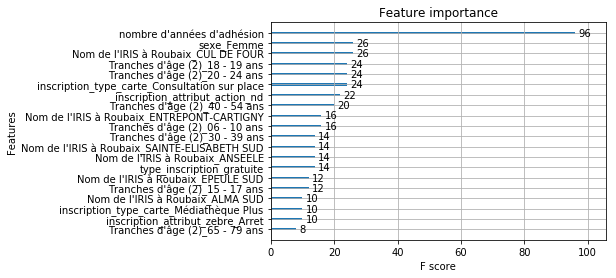

In [40]:
# importance des variables
plot_importance(model, max_num_features = 20)

### Réseau de neurones

In [41]:
dummy_y_train = to_categorical(y_train)
dummy_y_test = to_categorical(y_test)

In [42]:
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, dummy_y_train, epochs=20, verbose=0)
y_pred_test = model.predict_classes(X_test)
print("Taux de classifications exactes sur le jeu de test :", metrics.accuracy_score(y_test, y_pred_test)) # 68.5
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.confusion_matrix(y_test, y_pred_test))

K.clear_session()

Taux de classifications exactes sur le jeu de test : 0.6850810453192193
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      2050
           1       0.51      0.65      0.57       973

   micro avg       0.69      0.69      0.69      3023
   macro avg       0.66      0.67      0.66      3023
weighted avg       0.71      0.69      0.69      3023

[[1443  607]
 [ 345  628]]
